In [1]:
# Characterizing Link Channel Impulse Response on POWDER

# Authors (alphabetical order):
# - Cassie Jeng
# - Neal Patwari
# - Aarti Singh
# - Jie Wang
# - Meles Gebreyesus Weldegebriel

# February 2025, Version 0.2

# This python notebook provides code to generate an IQ file with PN codes that can be transmitted between 
# nodes on POWDER using the Shout framework and shows the channel impulse response and multipath resulting 
# from cross-correlating the filtered received signal with the original PN code packet.

In [25]:
# Standard packages
import argparse
import sys
import os
import subprocess
import json
import datetime

# IQ Generation packages
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import lfilter

# PN Generation packages
# !pip install pylfsr
import pylfsr
from pylfsr import LFSR

# Other packages
import itertools
import scipy.io as sio
from scipy import signal, stats
from scipy.signal import find_peaks
import h5py
from matplotlib import rc
rc('xtick',labelsize=14)
rc('ytick',labelsize=14)

In [3]:
# 1. Create an IQ file from PN codes

# IQ Generation functions

# PURPOSE: Create QPSK bits for transmit
# INPUT: inphase and quadrature bits
# OUTPUT: QPSK_bits to transmit
def Information_Transmit_r(inphase, quad):
    in_phase = np.asarray(inphase)
    quadrature = np.asarray(quad)
    QPSK_bits = np.vstack([in_phase, quadrature])
    return QPSK_bits

# PURPOSE: List allowed PN taps based on specified number of stages
# INPUT: N_stages between 7 and 11
# OUTPUT: L_codelen PN code length, ptaps allowed taps
def choose_taps(N_stages):
    L_codelen = (2 ** N_stages) - 1
    if N_stages == 7:
        ptaps = '[7,6] [7,3] [7,1]'
    elif N_stages == 8:
        ptaps = '[8,6,5,4] [8,6,5,3]'
    elif N_stages == 9:
        ptaps = '[9,5] [9,6,4,3]'
    elif N_stages == 10:
        ptaps = '[10,7] [10,3]'
    elif N_stages == 11:
        ptaps = '[11,9] [11,8,5,2]'
    elif N_stages == 12:
        ptaps = '[12,6,4,1]'
    elif N_stages == 13:
        ptaps = '[13,4,3,1]'
    elif N_stages == 14:
        ptaps = '[14,5,3,1]'
    else:
        ptaps = ''
    return L_codelen, ptaps

# PURPOSE: Convert input data to signal space values
# INPUT: data bits, inputVec, outputVec coding
# OUTPUT: output values from outputVec
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('ERROR in function lut: Input and Output vectors must have identical length')
        exit()
    output = np.zeros(data.shape)
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

# PURPOSE: Insert 0's between samples to oversample at OS_Rate
# INPUT: x data to oversample, OS_Rate rate to sample
# OUTPUT: x_s oversampled data
def oversample(x, OS_Rate):
    length = len(x[0])
    x_s = np.zeros((1,length*OS_Rate))
    # Fill in one out of every OS_Rate samples with the input values
    count = 0
    h = 0
    for k in range(len(x_s[0])):
        count = count + 1
        if count == OS_Rate:
            x_s[0][k] = x[0][h]
            count = 0
            h = h + 1
    return x_s

# PURPOSE: Create a Square Root Raised Cosine pulse shape
# INPUT: alpha, N, Lp
# OUTPUT: pulse shape for SRRC
def SRRC(alpha, N, Lp):
    # Add epsilon to the n values to avoid numerical problems
    ntemp = list(range(-N*Lp, N*Lp+1))
    n = []
    for each in ntemp:
        n.append(each + math.pow(10,-9))
    # Plug into time domain formula for the SRRC pulse shape
    h = []
    coeff = 1/math.sqrt(N)
    for each in n:
        sine_term = math.sin(math.pi * each * (1-alpha) / N)
        cosine_term = math.cos(math.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = math.pi * each / N
        denom_part = 1 - math.pow(cosine_coeff, 2)
        denominator = denom_coeff * denom_part
        pulse = coeff * numerator / denominator
        h.append(pulse)
    return h

# PURPOSE: Open filename and write array to it as binary
# INPUT: data to write as binary, filename to write to
# OUTPUT: file with complex binary data
def write_complex_binary(data, filename):
    # Open filename and write array to it as binary, format is interleaved float IQ
    re = np.real(data)
    im = np.imag(data)
    binary = np.zeros(len(data)*2, dtype=np.float32)
    binary[::2] = re
    binary[1::2] = im
    binary.tofile(filename)

# PURPOSE: Load samples from binary file
# INPUT: filename to load complex binary from
# OUTPUT: samps from file
def get_samps_from_file(filename):
    # File should be in GNURadio's format, i.e., interleaved I/Q samples as float32
    samples = np.fromfile(filename, dtype= np.float32)
    samps = (samples[::2] + 1j*samples[1::2]).astype((np.complex64)) # convert to IQIQIQ
    return samps

In [4]:
# PN code generation

# The variables `samples_per_chip`, `samp_rate`, and `alpha` can be adjusted to see different Channel 
# Impulse Responses and the varying affects of multipath depending on the resolution. For example, doubling 
# the `samp_rate` should cause the resulting peaks to be twice as narrow. You can also increase the `alpha` 
# value to decrease the amplitude of the side lobes. Because of the limited bandwidth available to each group 
# during class, this could be interesting to explore on your own. For example, with a resolution of 25 
# nanoseconds, you could see the multipath separate even further, but would also need 40 MHz of bandwidth.

samples_per_chip = 2
samp_rate = 56000000.0
#samp_rate = 250000.0
alpha = 0.75
A = math.sqrt(9/2)
Lp = 6

N_stages = 14
L_codelen, ptaps = choose_taps(N_stages)
print('Code length L = ' + str(L_codelen))
print('Valid taps to choose: ' + ptaps)

Code length L = 16383
Valid taps to choose: [14,5,3,1]


In [5]:
# PN code generation

# In-Phase Sequence
state = '0,0,0,0,0,0,0,0,0,0,0,1,0,0'
taps = '14,5,3,1'

state = state.split(',')
state = [int(s) for s in state]

taps = taps.split(',')
taps = [int(t) for t in taps]

L = LFSR(initstate=state, fpoly=taps)
pn_iSeq = L.getFullPeriod()

# Quadrature Sequence
state = '0,0,0,0,0,0,0,0,1,0,0,0,0,0'
taps = '14,5,3,1'

state = state.split(',')
state = [int(s) for s in state]

taps = taps.split(',')
taps = [int(t) for t in taps]

L = LFSR(initstate=state, fpoly=taps)
pn_qSeq = L.getFullPeriod()

# ----- Uncomment if you want to see the PN code bit sequences
# print('\nPN In-Phase Sequence:\n',pn_iSeq)
# print('\nPN Quadrature Sequence:\n',pn_qSeq)

Frame = Information_Transmit_r(pn_iSeq, pn_qSeq)

# Modulation
# INPUT: data
# OUTPUT: modulated values, x
xI_list = []
for each in Frame[0]:
    if each == 0:
        xI_list.append(-1)
    else:
        xI_list.append(1)

xQ_list = []
for each in Frame[1]:
    if each == 0:
        xQ_list.append(-1) # -1j
    else:
        xQ_list.append(1) # 1j
xI_list_new = [i * A for i in xI_list]
xQ_list_new = [i * A for i in xQ_list]

xI = np.array(xI_list_new)
xQ = np.array(xQ_list_new)

xI = xI.reshape((1,len(Frame[0])))
xQ = xQ.reshape((1,len(Frame[1])))

# Oversample
# INPUT: modulated values, x
# OUTPUT: modulated values at sampling rate, samples_per_chip
x_s_I = oversample(xI,samples_per_chip)
x_s_Q = oversample(xQ,samples_per_chip)

pulse = SRRC(alpha,samples_per_chip,Lp)
pulse = np.array(pulse)
pulse = np.reshape(pulse,pulse.size)

x_s_I = np.reshape(x_s_I, x_s_I.size)
x_s_Q = np.reshape(x_s_Q, x_s_Q.size)
s_0_I = np.convolve(x_s_I, pulse, mode='full')
s_0_Q = np.convolve(x_s_Q, pulse, mode='full')

# Create complex IQ values from the I and Q components
# For this tutorial we are choosing to transmit just the real I components
# QPSK_samples = s_0_I + s_0_Q*1j
QPSK_samples = s_0_I

# Transmit 3 copies of PN code packet
numPN = 3
P = len(pulse)-1
P2 = int(P/2)
oversample_PNlen = samples_per_chip*L_codelen
QPSK_samples_add = np.zeros((oversample_PNlen*numPN)+P, dtype=type(QPSK_samples[0]))

for i in range(numPN):
    QPSK_samples_add[i*oversample_PNlen:(i*oversample_PNlen)+oversample_PNlen+P] += QPSK_samples

QPSK_samples_Final = np.hstack([np.zeros(1024, dtype=type(QPSK_samples[0])),QPSK_samples_add])

In [6]:
# IQ_filename = 'bw-joint-small'
# IQ_filename = IQ_filename + '.iq'
# write_complex_binary(QPSK_samples_Final,IQ_filename)

# print('IQ file generated')

## ----- Uncomment if you want to see the complex binary written to the file
## print('\n')
## print(get_samps_from_file(IQ_filename)[-150:-140])

In [7]:
# 2. Use Shout to Transmit and Receive Between Two Nodes

# 1. Copy IQ file from host to POWDER nodes (orch and all clients)
#    scp <IQ_FILENAME.iq> <USERNAME>@<HOSTNAME>:/local/repository/shout/signal_library
#
# scp bw-joint-small.iq jengc@pc842.emulab.net:/local/repository/shout/signal_library
# scp bw-joint-small.iq jengc@pc855.emulab.net:/local/repository/shout/signal_library
# scp bw-joint-small.iq jengc@pc852.emulab.net:/local/repository/shout/signal_library
# scp bw-joint-small.iq jengc@pc837.emulab.net:/local/repository/shout/signal_library
# scp bw-joint-small.iq jengc@pc838.emulab.net:/local/repository/shout/signal_library
# scp bw-joint-small.iq jengc@pc839.emulab.net:/local/repository/shout/signal_library
# scp bw-joint-small.iq jengc@pc847.emulab.net:/local/repository/shout/signal_library
# scp bw-joint-small.iq jengc@cnode-ebc.emulab.net:/local/repository/shout/signal_library
# scp bw-joint-small.iq jengc@cnode-mario.emulab.net:/local/repository/shout/signal_library
# scp bw-joint-small.iq jengc@cnode-ustar.emulab.net:/local/repository/shout/signal_library
# scp bw-joint-small.iq jengc@cnode-guesthouse.emulab.net:/local/repository/shout/signal_library
# scp bw-joint-small.iq jengc@cnode-moran.emulab.net:/local/repository/shout/signal_library

# 2. Open two orchestrator sessions
#    ssh -Y -p 22 -t <USERNAME>@<HOSTNAME> 'cd /local/repository/bin && tmux new-session -A -s orch1 &&  exec $SHELL'
#    ssh -Y -p 22 -t <USERNAME>@<HOSTNAME> 'cd /local/repository/bin && tmux new-session -A -s orch2 &&  exec $SHELL'
#
# ssh -Y -p 22 -t jengc@pc842.emulab.net 'cd /local/repository/bin && tmux new-session -A -s orch1 &&  exec $SHELL'
# ssh -Y -p 22 -t jengc@pc842.emulab.net 'cd /local/repository/bin && tmux new-session -A -s orch2 &&  exec $SHELL'

# 3. Connect to the client nodes
#    ssh -Y -p 22 -t <USERNAME>@<HOSTNAME> 'cd /local/repository/bin && tmux new-session -A -s client1 &&  exec $SHELL'
#    ssh -Y -p 22 -t <USERNAME>@<HOSTNAME> 'cd /local/repository/bin && tmux new-session -A -s client2 &&  exec $SHELL'
#
# ssh -Y -p 22 -t jengc@pc855.emulab.net 'cd /local/repository/bin && tmux new-session -A -s client1 &&  exec $SHELL'
# ssh -Y -p 22 -t jengc@pc852.emulab.net 'cd /local/repository/bin && tmux new-session -A -s client1 &&  exec $SHELL'
# ssh -Y -p 22 -t jengc@pc837.emulab.net 'cd /local/repository/bin && tmux new-session -A -s client1 &&  exec $SHELL'
# ssh -Y -p 22 -t jengc@pc838.emulab.net 'cd /local/repository/bin && tmux new-session -A -s client1 &&  exec $SHELL'
# ssh -Y -p 22 -t jengc@pc839.emulab.net 'cd /local/repository/bin && tmux new-session -A -s client1 &&  exec $SHELL'
# ssh -Y -p 22 -t jengc@pc847.emulab.net 'cd /local/repository/bin && tmux new-session -A -s client1 &&  exec $SHELL'
#
# ssh -Y -p 22 -t jengc@cnode-ebc.emulab.net 'cd /local/repository/bin && tmux new-session -A -s client1 &&  exec $SHELL'
# ssh -Y -p 22 -t jengc@cnode-mario.emulab.net 'cd /local/repository/bin && tmux new-session -A -s client2 &&  exec $SHELL'
# ssh -Y -p 22 -t jengc@cnode-ustar.emulab.net 'cd /local/repository/bin && tmux new-session -A -s client3 &&  exec $SHELL'
# ssh -Y -p 22 -t jengc@cnode-guesthouse.emulab.net 'cd /local/repository/bin && tmux new-session -A -s client4 &&  exec $SHELL'
# ssh -Y -p 22 -t jengc@cnode-moran.emulab.net 'cd /local/repository/bin && tmux new-session -A -s client5 &&  exec $SHELL'

# 4. Edit `save_iq_w_tx_file.json`
#    Change `txfreq` and `rxfreq`
#    Change `txsamps` to specify your IQ file name
#    Change `txclients` and `rxclients` to have your comp nodes in ID column
#    Change `txgain` and `rxgain` (depending on if using X310 or B210 radios)
#        X310: TX: 27.0, RX: 30.0
#        B210: TX: 85.0, RX: 70.0
#    Copy `save_iq_w_tx_file.json` to `/local/repository/etc/cmdfiles` (orch and all clients)
#
# scp save_iq_w_tx_file.json jengc@pc842.emulab.net:/local/repository/etc/cmdfiles
# scp save_iq_w_tx_file.json jengc@pc855.emulab.net:/local/repository/etc/cmdfiles
# scp save_iq_w_tx_file.json jengc@pc852.emulab.net:/local/repository/etc/cmdfiles
# scp save_iq_w_tx_file.json jengc@pc837.emulab.net:/local/repository/etc/cmdfiles
# scp save_iq_w_tx_file.json jengc@pc838.emulab.net:/local/repository/etc/cmdfiles
# scp save_iq_w_tx_file.json jengc@pc839.emulab.net:/local/repository/etc/cmdfiles
# scp save_iq_w_tx_file.json jengc@pc847.emulab.net:/local/repository/etc/cmdfiles
# scp save_iq_w_tx_file.json jengc@cnode-ebc.emulab.net:/local/repository/etc/cmdfiles
# scp save_iq_w_tx_file.json jengc@cnode-mario.emulab.net:/local/repository/etc/cmdfiles
# scp save_iq_w_tx_file.json jengc@cnode-ustar.emulab.net:/local/repository/etc/cmdfiles
# scp save_iq_w_tx_file.json jengc@cnode-guesthouse.emulab.net:/local/repository/etc/cmdfiles
# scp save_iq_w_tx_file.json jengc@cnode-moran.emulab.net:/local/repository/etc/cmdfiles

# 5. In one of the orchestrator terminal sessions, run:
# ./1.start_orch.sh

# 6. In all client sessions, run and then wait for the clients to say "Waiting for command...":
# sudo sysctl -w net.core.wmem_max=24862979
# ./2.start_client.sh

# REMINDER: If firmware mismatch issue, run commands, power-cycle radios, and restart experiment:
# sudo uhd_images_downloader -t x3
# sudo uhd_image_loader --args="type=x300,addr=192.168.40.2"

# 7. In the second orchestrator terminal session, run:
# ./3.run_cmd.sh

# 8. After second orch returns to command prompt, run & copy Shout data folder to host:
# ls /local/data
# scp -r <USERNAME>@<HOSTNAME>:/local/data/<SHOUT_DATA_FOLDER> .
#
# scp -r jengc@pc842.emulab.net:/local/data/<SHOUT_DATA_FOLDER> .

In [8]:
# 3. Cross-Correlation and Channel Impulse Response from Collected Data

# Reading data functions

# PURPOSE: Get data and time from timestamp
# INPUT: timestamp
# OUTPUT: data and time, example: 01-04-2023, 19:50:27
def get_time_string(timestamp):
    date_time = datetime.datetime.fromtimestamp(int(timestamp))
    return date_time.strftime("%m-%d-%Y, %H:%M:%S")

# PURPOSE: Load parameters from the saved json file
# INPUT: data folder, saved json_file
# OUTPUT: experiment specifications from json file
def JsonLoad(folder, json_file):
    config_file = folder+'/'+json_file
    config_dict = json.load(open(config_file))[0]
    nsamps = config_dict['nsamps']
    rxrate = config_dict['rxrate']
    rxfreq = config_dict['rxfreq']
    wotxrepeat = config_dict['wotxrepeat']
    rxrepeat = config_dict['rxrepeat']
    txnodes = config_dict['txclients']
    rxnodes = config_dict['rxclients']
    return rxrepeat, rxrate, txnodes, rxnodes

# PURPOSE: Load data from hdf5 format measurement file
# INPUT: meas_folder path to measurement folder
# OUTPUT: data, noise, and txrxloc node names
def traverse_dataset(meas_folder):
    data = {}
    noise = {}
    txrxloc = {}

    dataset = h5py.File(meas_folder + '/measurements.hdf5', "r")
    for cmd in dataset.keys():
        if cmd == 'saveiq':
            cmd_time = list(dataset[cmd].keys())[0]
            # ----- Uncomment to see time stamps
            # print('Time Collected:', get_time_string(cmd_time))
            # print('Command meta data:', list(dataset[cmd][cmd_time].attrs.items()))
        elif cmd == 'saveiq_w_tx':
            cmd_time = list(dataset[cmd].keys())[0]
            # ----- Uncomment to see time stamps
            # print('Time Collected:', get_time_string(cmd_time))
            # print('Command meta data:', list(dataset[cmd][cmd_time].attrs.items()))
            for tx in dataset[cmd][cmd_time].keys():
                if tx == 'wo_tx':
                    for rx_gain in dataset[cmd][cmd_time][tx].keys():
                        for rx in dataset[cmd][cmd_time][tx][rx_gain].keys():
                            repeat = np.shape(dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'])[0]
                            samplesNotx = dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'][:repeat, :]
                            namelist = rx.split('-')
                            noise[namelist[1]] = samplesNotx
                else:
                    for tx_gain in dataset[cmd][cmd_time][tx].keys():
                        for rx_gain in dataset[cmd][cmd_time][tx][tx_gain].keys():
                            for rx in dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys():
                                repeat = np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'])[0]
                                txrxloc.setdefault(tx, []).extend([rx]*repeat)
                                rxsamples = dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'][:repeat, :]
                                data.setdefault(tx, []).append(np.array(rxsamples))
        else:
            print('Unsupported command: ', cmd)
    return data, noise, txrxloc

In [9]:
# Access JSON information

#folder = 'Shout_meas_02-25-2025_13-57-05'
#folder = 'Small_Rooftop_Shout_meas_02-20-2025_14-54-10'

#folder = 'Rooftop_Shout_meas_02-19-2025_12-47-00'
folder = 'Dense-Deployment_Shout_meas_02-18-2025_11-38-19'

jsonfile = 'save_iq_w_tx_file.json'
rxrepeat, samp_rate, txlocs, rxlocs = JsonLoad(folder, jsonfile)
print('txlocs:')
print(txlocs)
print('\nrxlocs:')
print(rxlocs)

# Load data from the HDF5 file, save IQ sample arrays
rx_data, _, txrxloc = traverse_dataset(folder)

rx_names = []
for rxl in rxlocs:
    rx_names.append(rxl.split('-')[1])

rx_names = sorted(rx_names)
print('\n ----- rx node names ----- ')
print(rx_names)

tx_names = []
for txl in txlocs:
    tx_names.append(txl.split('-')[1])

tx_names = sorted(tx_names)
print('\n ----- tx node names ----- ')
print(tx_names)

txlocs:
['cnode-ebc-dd-b210', 'cnode-mario-dd-b210', 'cnode-ustar-dd-b210', 'cnode-guesthouse-dd-b210', 'cnode-moran-dd-b210']

rxlocs:
['cnode-ebc-dd-b210', 'cnode-mario-dd-b210', 'cnode-ustar-dd-b210', 'cnode-guesthouse-dd-b210', 'cnode-moran-dd-b210']

 ----- rx node names ----- 
['ebc', 'guesthouse', 'mario', 'moran', 'ustar']

 ----- tx node names ----- 
['ebc', 'guesthouse', 'mario', 'moran', 'ustar']


In [10]:
# CIR functions

# PURPOSE: Cross-correlate received signal with transmitted signal.
#          Highest amplitude corresponds to the index delay where the
#          transmitted packet is found in the received packet.
# INPUT: rx0 received signal, packetSignal transmitted PN code packet
# OUTPUT: lagIndex highest correlation delay index, lags, xcorr_mag, peak
def crossCorrelationMax(rx0, packetSignal):
    # Cross correlate with the original packet to find it in the noisy signal
    lags = signal.correlation_lags(len(rx0), len(packetSignal), mode='same')
    xcorr_out = signal.correlate(rx0, packetSignal, mode='same')
    xcorr_mag = np.abs(xcorr_out)

    length_of_packet = len(packetSignal)
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)-length_of_packet])
    lagIndex = lags[maxIndex]
    peak = lags[np.argmax(xcorr_mag)]

    plt.figure()
    plt.plot(((lags/samp_rate)*1000000), xcorr_mag, label='|X-Correlation|')
    plt.legend()
    plt.plot(((peak/samp_rate)*1000000), xcorr_mag[peak], 'xr')
    plt.ylabel('|X-Correlation| with TX Packet', fontsize=14)
    plt.xlabel('Time (us)', fontsize=14)
    plt.tight_layout()
    plt.show()

    return lagIndex, lags, xcorr_mag, peak

# PURPOSE: Convert samples to microseconds
# INPUT: value in samples
# OUTPUT: time value in microseconds (us)
def samples_to_us(value, samp_rate):
    return (float)((value/samp_rate)*1000000)

In [11]:
# Finding the Kernel Distance between experimental CIR and RT CIR

# Gaussian Kernel Distance
# K(x,y) = exp(-||x-y||^2/sigma^2)
# K(x,x) = 1

def gaussian_kernel_K(p, q, sigma=1.0):
    return np.exp(-1 * np.sum((p-q)**2) / (sigma**2))

# Gaussian Kernel Distance
# k_pp' + k_qq' - 2 * k_pq

def kernel_dist(cir, rt_cir, sigma=1.0):
    distance = 0
    for p in cir:
        for pp in cir:
            distance += gaussian_kernel_K(p,pp)
    
    for q in rt_cir:
        for qp in rt_cir:
            distance += gaussian_kernel_K(q,qp)
    
    sub_dist = 0
    for p in cir:
        for q in rt_cir:
            sub_dist += gaussian_kernel_K(p,q)
    
    distance = distance - (2*sub_dist)
    return distance

In [12]:
# JSON of RT CIR with correct heights, more allowed reflections, more samples collected (more tx signals sent)
# "tx-rx": [f_rttau, f_rta]
# rt_results_dict = {}
# rt_json = json.loads(json.dumps(rt_results_dict))

# rt_json_filename = 'RTcir_rt_nheight.json'
# rt_json_filename = 'RTcir_rt.json'
# rt_json_filename = 'RTcir_dd.json'
rt_json_filename = 'RTcir_dd_diff.json'

with open(rt_json_filename, 'r') as jsonfile:
    rt_json = json.load(jsonfile)[0]

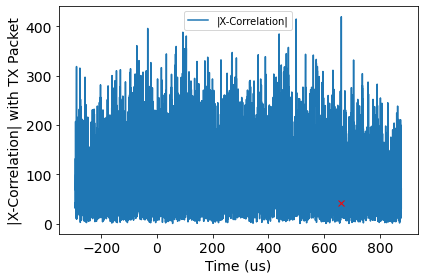

Plotnum: 0, TX: cnode-ebc-dd-b210, RX: cnode-mario-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 110.10326314184766


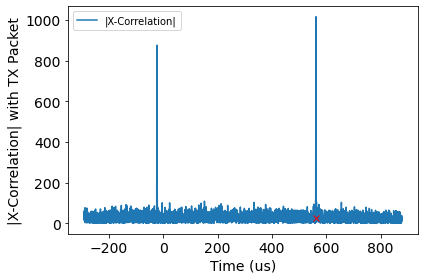

Plotnum: 1, TX: cnode-ebc-dd-b210, RX: cnode-ustar-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 7017.644837416382


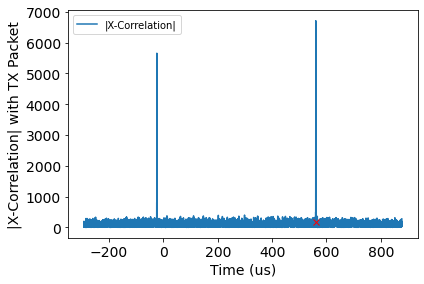

Plotnum: 2, TX: cnode-ebc-dd-b210, RX: cnode-guesthouse-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 4699.962067759365


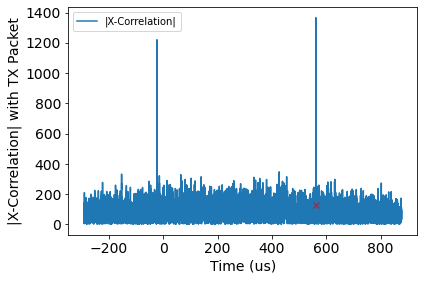

Plotnum: 3, TX: cnode-ebc-dd-b210, RX: cnode-moran-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 4708.357874841161


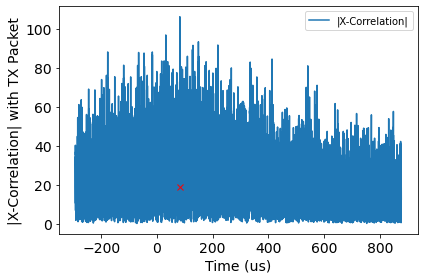

Plotnum: 4, TX: cnode-mario-dd-b210, RX: cnode-ebc-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 111.7474898877372


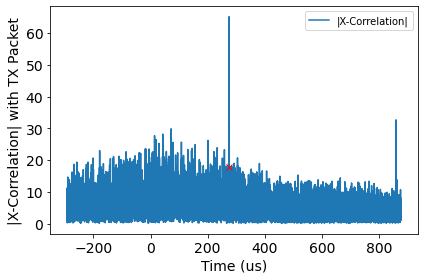

Plotnum: 5, TX: cnode-mario-dd-b210, RX: cnode-ustar-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 107.64384115610171


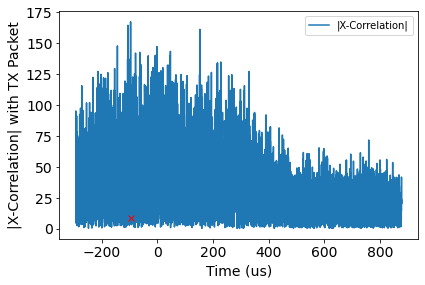

Plotnum: 6, TX: cnode-mario-dd-b210, RX: cnode-guesthouse-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 2.0


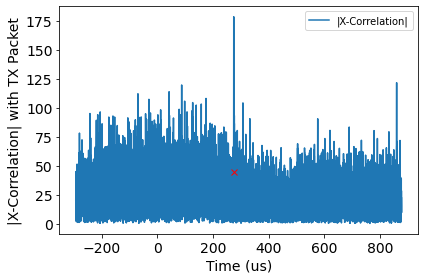

Plotnum: 7, TX: cnode-mario-dd-b210, RX: cnode-moran-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 42.00000257995977


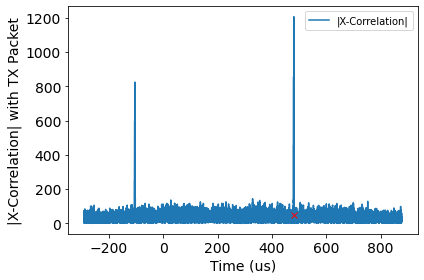

Plotnum: 8, TX: cnode-ustar-dd-b210, RX: cnode-ebc-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 6997.483233751676


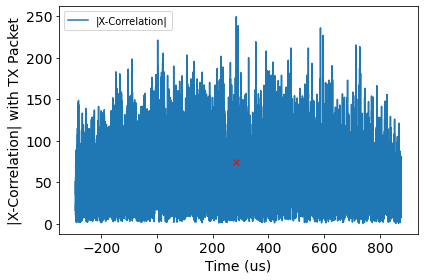

Plotnum: 9, TX: cnode-ustar-dd-b210, RX: cnode-mario-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 110.88122151254204


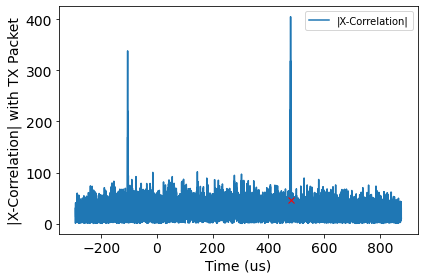

Plotnum: 10, TX: cnode-ustar-dd-b210, RX: cnode-guesthouse-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 5000.003262977504


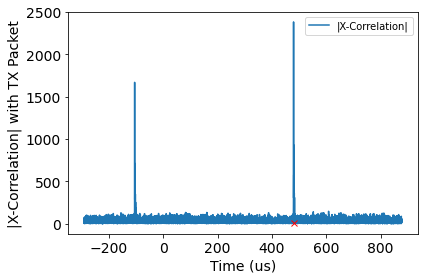

Plotnum: 11, TX: cnode-ustar-dd-b210, RX: cnode-moran-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 4294.968917436543


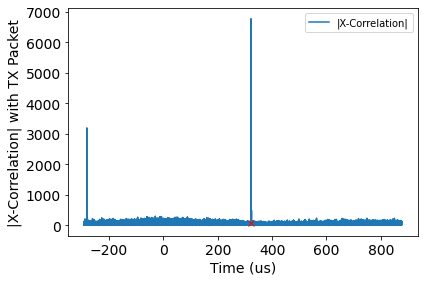

Plotnum: 12, TX: cnode-guesthouse-dd-b210, RX: cnode-ebc-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 4563.087841012368


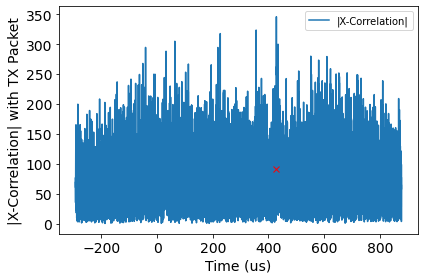

Plotnum: 13, TX: cnode-guesthouse-dd-b210, RX: cnode-mario-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 2.0


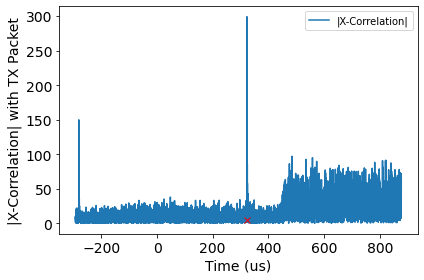

Plotnum: 14, TX: cnode-guesthouse-dd-b210, RX: cnode-ustar-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 5066.103795803632


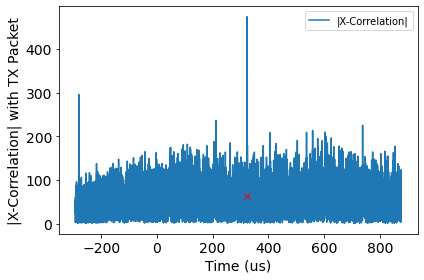

Plotnum: 15, TX: cnode-guesthouse-dd-b210, RX: cnode-moran-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 2458.856698595309


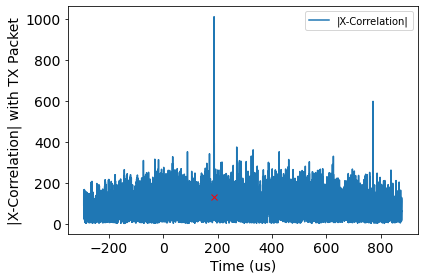

Plotnum: 16, TX: cnode-moran-dd-b210, RX: cnode-ebc-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 4847.630408939427


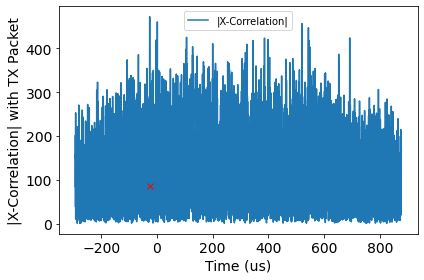

Plotnum: 17, TX: cnode-moran-dd-b210, RX: cnode-mario-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 71.99999999676311


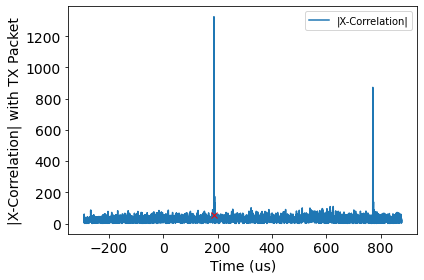

Plotnum: 18, TX: cnode-moran-dd-b210, RX: cnode-ustar-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 4720.0476087061


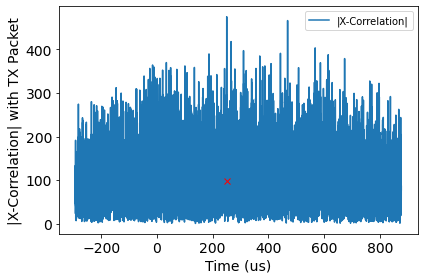

Plotnum: 19, TX: cnode-moran-dd-b210, RX: cnode-guesthouse-dd-b210
Gaussian Kernel
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,rt_cir) = 2674.66592595424


In [13]:
# Cross Correlation & Delays

filtered_rx0_list = []
pairnames = []
kernel_dists = []
plotnum = 0

for tx in txlocs:
    for rx in rxlocs:
        if tx != rx:
            for repNum in range(rxrepeat):
                txloc = tx
                rxloc = rx

                rx_data[txloc] = np.vstack(rx_data[txloc])
                rxloc_arr = np.array(txrxloc[txloc])
                rx0 = rx_data[txloc][rxloc_arr==rxloc][repNum]

                # Low Pass Filtering to out_of_band frequency components
                stopband_attenuation = 60.0
                transition_bandwidth = 0.05
                cutoff_norm = 0.15
                filterN, beta = signal.kaiserord(stopband_attenuation, transition_bandwidth)
                taps = signal.firwin(filterN, cutoff_norm, window=('kaiser', beta))
                filtered_rx0 = signal.lfilter(taps, 1.0, rx0)
                filtered_rx0_list.append(filtered_rx0)

                packetSignal = QPSK_samples
                lagIndex, lags, xcorr_mag, peak = crossCorrelationMax(filtered_rx0, packetSignal)
                print('Plotnum: ' + str(plotnum) + ', TX: ' + txloc + ', RX: ' + rxloc)
                plotnum += 1
                
                # Find associated RT results in JSON
                tname = txloc.split('-')[1]
                rname = rxloc.split('-')[1]
                pairname = tname + '-' + rname
                pairnames.append(pairname)
                #print(pairname)
                # "tx-rx": [f_rttau, f_rta]
                f_rttau = rt_json[pairname][0] #x
                f_rta = rt_json[pairname][1] #y
                
                peak_ind = np.where(lags == peak)[0][0]
                a = [x * 1000000 for x in f_rta]
                
                cir = []
                for i in range(0,len(f_rttau)):
                    cir.append(xcorr_mag[peak_ind + i])

                cir = np.array(cir)
                rt_cir = np.array(f_rta)
                
                K = gaussian_kernel_K(cir, rt_cir)
                print('Gaussian Kernel')
                print('K(cir,rt_cir) = ' + str(K))
                DK = kernel_dist(cir,rt_cir)
                print('\nGaussian Kernel Distance')
                print('DK(cir,rt_cir) = ' + str(DK))
                kernel_dists.append(DK)

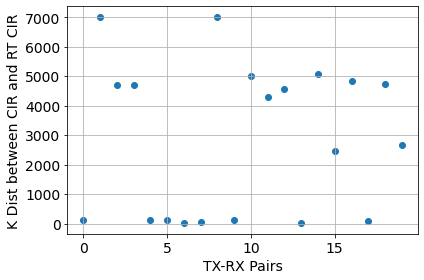

In [14]:
# Showing all CIR to RT_CIR Kernel Distances

sx = list(range(0,len(kernel_dists)))

plt.figure()
plt.scatter(sx, kernel_dists)
plt.ylabel('K Dist between CIR and RT CIR', fontsize=14)
plt.xlabel('TX-RX Pairs', fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()

ebc-guesthouse


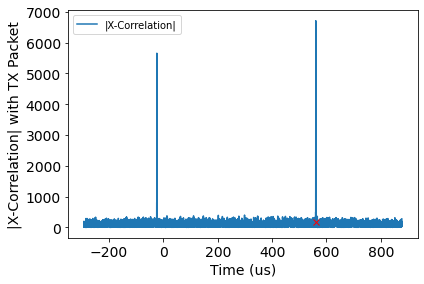

RX Time Delay: -24.196428571428573 us


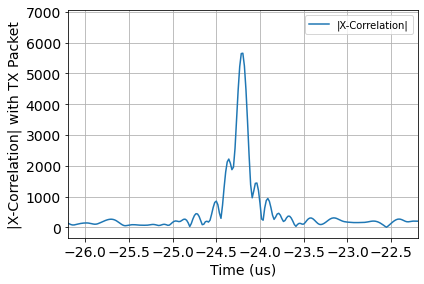

In [31]:
# Look closer at Cross-Correlation Peak

# plotnum = 8 # tx: browning, rx: hospital
# plotnum = 5 # tx: browning, rx: bes
plotnum = 2

filtered_rx0 = filtered_rx0_list[plotnum]
pairname = pairnames[plotnum]
print(pairname)

lagIndex, lags, xcorr_mag, peak = crossCorrelationMax(filtered_rx0, QPSK_samples)
print('RX Time Delay: ' + str(samples_to_us(lagIndex,samp_rate)) + ' us')

# Change lagIndex if a different peak is desired to analyze in zoomed plot

# Zoom in on cross-correlation peak
us_around = 2
lagIndex_us = samples_to_us(lagIndex,samp_rate)

plt.figure()
plt.plot(((lags/samp_rate)*1000000), xcorr_mag, label='|X-Correlation|')
plt.legend()
plt.ylabel('|X-Correlation| with TX Packet', fontsize=14)
plt.xlabel('Time (us)', fontsize=14)
plt.xlim((lagIndex_us-us_around,lagIndex_us+us_around))
plt.tight_layout()
plt.grid(True)
plt.show()

Peak index: 47806 (560.9107142857143us)
CIR peak us:
6712.358540594549
RT CIR peak us:
31.455080000000002
[560.7700442857143, 741.9066942857144, 561.3107642857143, 560.9107142857143, 740.5037042857143, 811.4650742857143, 993.3706342857143, 767.9323842857143, 1216.7540842857143, 1176.7950642857145, 611.1690442857143, 615.2318342857143, 684.7905642857144, 574.0328842857143, 575.7272842857143, 575.3398342857143, 578.3267742857144, 581.2161942857143, 670.6983242857143, 687.1246142857143, 785.6957742857144, 794.4007742857143, 599.9622942857143, 599.5204642857143, 603.8026242857144, 602.1854942857143, 604.3151242857143, 621.9850342857144, 621.8206642857143, 624.6111042857143, 603.8859242857143, 608.1049842857143, 608.6018342857143, 618.8861442857143, 610.0349742857144, 613.1772242857144, 626.8525542857143, 669.7233042857143, 817.8412742857143, 741.9404542857144, 743.2660942857144, 742.2499542857144, 674.3251342857143, 620.3558642857143, 595.9810642857143, 767.1726642857143, 768.1432942857143

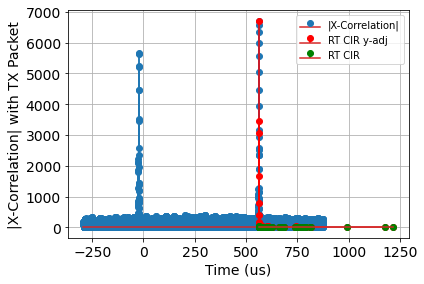

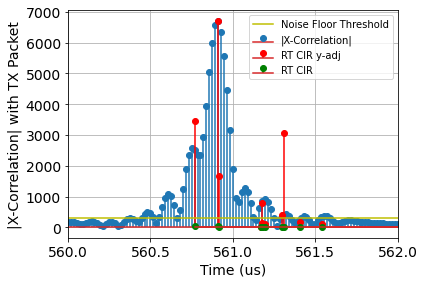

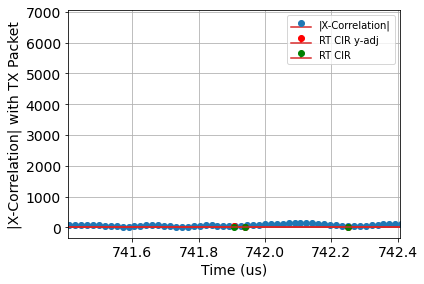

In [64]:
# Zoom in on Cross-Correlation Peak
## Algorithm Cell

# calculating appropriate zoom based on samp_rate
# samp_rate_mag_diff = len('56000000')-len(str(samp_rate).split('.')[0])
# largest_samp_rate_zoom = 5 #smallest zoom
# samp_rate_zoom = largest_samp_rate_zoom*(10**samp_rate_mag_diff)
# us_around = samp_rate_zoom

# matching x axis
def xaxis_match(oldx, peak, oldy):
    my = oldy.index(max(oldy))
    newx = [(x - oldx[my] + peak) for x in oldx]
    #newx = [(x - oldx[0] + peak) for x in oldx]
    return newx

def yaxis_match(oldy, peak):
    my = oldy.index(max(oldy))
    newy = [y * (peak/oldy[my]) for y in oldy]
    #newy = [y * (peak/oldy[0]) for y in oldy]
    return newy

#RT CIR results
f_rttau = rt_json[pairname][0] #x
f_rta = rt_json[pairname][1] #y

#RT results from seconds to us to match CIR plot
tau = [x * 100000000 for x in f_rttau]
a = [x * 1000000 for x in f_rta]

peak_ind = np.where(lags == peak)[0][0]
peakIndex_us = samples_to_us(peak,samp_rate)
print('Peak index: ' + str(peak_ind) + ' (' + str(peakIndex_us) + 'us)')

tau_plot = xaxis_match(tau, peakIndex_us, a)
a_plot = yaxis_match(a, xcorr_mag[peak_ind])

print('CIR peak us:')
print(xcorr_mag[peak_ind])
print('RT CIR peak us:')
print(a[0])
print(tau_plot)

# STEM plot
plt.figure()
plt.stem(((lags/samp_rate)*1000000), xcorr_mag, label='|X-Correlation|')
plt.stem(tau_plot, a_plot, label='RT CIR y-adj', linefmt='r-', markerfmt='ro')
plt.stem(tau_plot, a, label='RT CIR', linefmt='g-', markerfmt='go')
plt.legend()
plt.ylabel('|X-Correlation| with TX Packet', fontsize=14)
plt.xlabel('Time (us)', fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()

###

# STEM zoomed 100 us around LOS peak
plt.figure()
plt.stem(((lags/samp_rate)*1000000), xcorr_mag, label='|X-Correlation|')
plt.stem(tau_plot, a_plot, label='RT CIR y-adj', linefmt='r-', markerfmt='ro')
plt.stem(tau_plot, a, label='RT CIR', linefmt='g-', markerfmt='go')
plt.axhline(y = 301.7166952863105, color = 'y', linestyle = '-', label='Noise Floor Threshold')
plt.legend()
plt.ylabel('|X-Correlation| with TX Packet', fontsize=14)
plt.xlabel('Time (us)', fontsize=14)
#plt.xlim((peakIndex_us-us_around,peakIndex_us+us_around))
plt.xlim((560,562))
plt.tight_layout()
plt.grid(True)
plt.show()

##

# STEM zoomed 500 ns around first mp peak
ns_around = 0.5
plt.figure()
plt.stem(((lags/samp_rate)*1000000), xcorr_mag, label='|X-Correlation|')
plt.stem(tau_plot, a_plot, label='RT CIR y-adj', linefmt='r-', markerfmt='ro')
plt.stem(tau_plot, a, label='RT CIR', linefmt='g-', markerfmt='go')
plt.legend()
plt.ylabel('|X-Correlation| with TX Packet', fontsize=14)
plt.xlabel('Time (us)', fontsize=14)
plt.xlim((tau_plot[1]-ns_around,tau_plot[1]+ns_around))
plt.tight_layout()
plt.grid(True)
plt.show()

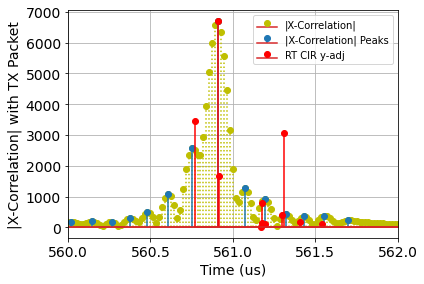

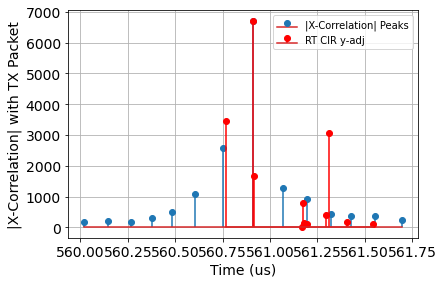

-- Total Received Power --
RT: 69.93 M
CIR (local peaks): 56.38 M
CIR (full): 1759.27 M

-- RMS Delay Spread --
RT: 0.15732544864311335 us
CIR (local peaks): 0.10931609167119324 us


In [75]:
# Calculations & Plots for Total Received Power and RMS Delay Spread

#finding local peaks for measured CIR
peak_indicies, _ = find_peaks(xcorr_mag)
peaks = []
peaks_lags = []
for each in peak_indicies:
    peaks.append(xcorr_mag[each])
    peaks_lags.append(lags[each])
peaks = np.array(peaks)
peaks_lags = np.array(peaks_lags)

# Local Peaks CIR Identified
plt.figure()
plt.stem(((lags/samp_rate)*1000000), xcorr_mag, label='|X-Correlation|', linefmt='y:')
plt.stem(((peaks_lags/samp_rate)*1000000), peaks, label='|X-Correlation| Peaks')
plt.stem(tau_plot, a_plot, label='RT CIR y-adj', linefmt='r-', markerfmt='ro')
#plt.stem(tau_plot, a, label='RT CIR', linefmt='g-', markerfmt='go')
#plt.axhline(y = 301.7166952863105, color = 'y', linestyle = '-', label='Noise Floor Threshold')
plt.legend()
plt.ylabel('|X-Correlation| with TX Packet', fontsize=14)
plt.xlabel('Time (us)', fontsize=14)
#plt.xlim((peakIndex_us-us_around,peakIndex_us+us_around))
plt.xlim((560,562))
#plt.ylim((0,2))
plt.tight_layout()
plt.grid(True)
plt.show()

# cropping to approximately 1us around peak of interest
sindex = 0
slook = True
eindex = 0
elook = False

for index,value in enumerate(peaks_lags):
    if ((value/samp_rate)*1000000) > (peakIndex_us-1) and slook:
        sindex = index
        slook = False
        elook = True
    if elook and ((value/samp_rate)*1000000) > (peakIndex_us+1):
        eindex = index
        break

peaks_cropped = peaks[sindex:eindex]
peaks_lags_cropped = peaks_lags[sindex:eindex]

# cropping for RT 1us around peak of interest
sindex = 0
slook = True
eindex = 0
elook = False

pairs_plot = []
for index, value in enumerate(tau_plot):
    pairs_plot.append([tau_plot[index], a_plot[index]])

pairs_plot.sort(key=lambda tauele: tauele[0])
a_plot_cropped = []
tau_plot_cropped = []
for each in pairs_plot:
    tau_plot_cropped.append(each[0])
    a_plot_cropped.append(each[1])
tau_plot_cropped = np.array(tau_plot_cropped)
a_plot_cropped = np.array(a_plot_cropped)

for index,value in enumerate(tau_plot_cropped):
    if value > (peakIndex_us-1) and slook:
        sindex = index
        slook = False
        elook = True
    if elook and value > (peakIndex_us+1):
        eindex = index
        break

tau_plot_cropped = tau_plot_cropped[sindex:eindex]
a_plot_cropped = a_plot_cropped[sindex:eindex]

lags_cropped = ((peaks_lags_cropped/samp_rate)*1000000)

# Local Peaks CIR Identified & Cropped to approximately 1us around peak of interest
plt.figure()
#plt.stem(((lags/samp_rate)*1000000), xcorr_mag, label='|X-Correlation|', linefmt='y:')
plt.stem(lags_cropped, peaks_cropped, label='|X-Correlation| Peaks')
plt.stem(tau_plot_cropped, a_plot_cropped, label='RT CIR y-adj', linefmt='r-', markerfmt='ro')
#plt.stem(tau_plot, a, label='RT CIR', linefmt='g-', markerfmt='go')
#plt.axhline(y = 301.7166952863105, color = 'y', linestyle = '-', label='Noise Floor Threshold')
plt.legend()
plt.ylabel('|X-Correlation| with TX Packet', fontsize=14)
plt.xlabel('Time (us)', fontsize=14)
#plt.xlim((peakIndex_us-us_around,peakIndex_us+us_around))
#plt.xlim((560,562))
#plt.ylim((0,2))
plt.tight_layout()
plt.grid(True)
plt.show()

# Received Power Calculations (using cropped data)
# P = sum[amplitudes]^2
cir_power_peaks = 0
#cir_power = 0
rt_power = 0
for each in peaks_cropped:
    cir_power_peaks += (each**2)
for each in xcorr_mag:
    cir_power += (each**2)
for each in a_plot_cropped:
    rt_power += (each**2)

print('-- Total Received Power --')
print('RT: ' + str(round(rt_power/1000000,2)) + ' M')
print('CIR (local peaks): ' + str(round(cir_power_peaks/1000000,2)) + ' M')
print('CIR (full): ' + str(round(cir_power/1000000,2)) + ' M')
#print('RT: ' + str(rt_power))
#print('CIR (local peaks): ' + str(cir_power_peaks))
#print('CIR (full): ' + str(cir_power))

# RMS Delay Spread Calculations (using cropped data)
# \tau_{rms} = \sqrt{\frac{\sum{P_h(\tau)*\tau^2}}{\sum{P_h(\tau)}} - 
#                   (\frac{\sum{P_h(\tau)*\tau}}{\sum{P_h(\tau)}})^2}

#cir calculation
tlags_cropped = lags_cropped - lags_cropped[0]
num1 = 0
denom = 0
num2 = 0
for i,p in enumerate(peaks_cropped):
    powerht = p**2
    
    num1 += powerht*tlags_cropped[i]
    denom += powerht
    
    num2 += powerht*(tlags_cropped[i]**2)

tau_mean = num1/denom
tau_bar_sq = num2/denom
CIRtrms = math.sqrt(tau_bar_sq - (tau_mean**2))

#rt calculation
ttau_plot_cropped = tau_plot_cropped - tau_plot_cropped[0]
num1 = 0
denom = 0
num2 = 0
for i,p in enumerate(a_plot_cropped):
    powerht = p**2
    
    num1 += powerht*ttau_plot_cropped[i]
    denom += powerht
    
    num2 += powerht*(ttau_plot_cropped[i]**2)

tau_mean = num1/denom
tau_bar_sq = num2/denom
RTtrms = math.sqrt(tau_bar_sq - (tau_mean**2))

print('\n-- RMS Delay Spread --')
print('RT: ' + str(RTtrms) + ' us')
print('CIR (local peaks): ' + str(CIRtrms) + ' us')

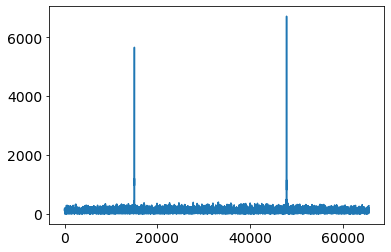

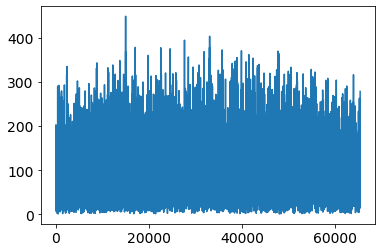

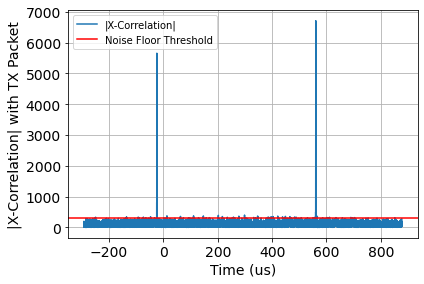

noise_std threshold: 301.7166952863105


In [17]:
# Calculating noise floor for link

noise_buffer = 25
noise_arr = np.concatenate((xcorr_mag[:peak_ind-noise_buffer], xcorr_mag[peak_ind+noise_buffer:]))

second_peak = max(noise_arr)
second_peak_ind = np.where(noise_arr == second_peak)[0][0]

noisearr = np.concatenate((noise_arr[:second_peak_ind-noise_buffer], noise_arr[second_peak_ind+noise_buffer:]))

# original xcorr_mag plot
plt.figure()
plt.plot(xcorr_mag)

# removed two peaks to leave noise
plt.figure()
plt.plot(noisearr)

noise_std = np.std(noisearr)
noise_std_thresh = 3.4*np.sqrt(2)*noise_std

plt.figure()
plt.plot(((lags/samp_rate)*1000000), xcorr_mag, label='|X-Correlation|')
#plt.axhline(y = noise_std, color = 'r', linestyle = '-', label='std') # std
#plt.axhline(y = noise_std_thresh, color = 'g', linestyle = '-', label='3.4sqrt(2)*std') # 3.4sqrt(2)*std above
plt.axhline(y = noise_std_thresh, color = 'r', linestyle = '-', label='Noise Floor Threshold') # 3.4sqrt(2)*std above
plt.legend()
plt.ylabel('|X-Correlation| with TX Packet', fontsize=14)
plt.xlabel('Time (us)', fontsize=14)
#plt.xlim((lagIndex_us-us_around,lagIndex_us+us_around))
plt.tight_layout()
plt.grid(True)
plt.show()

print('noise_std threshold: ' + str(noise_std_thresh))

RT CIR at 560.7700442857143 us is 20.044285714334364 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 2583.195
Scaled RT CIR amplitude: 3458.606

MATCH


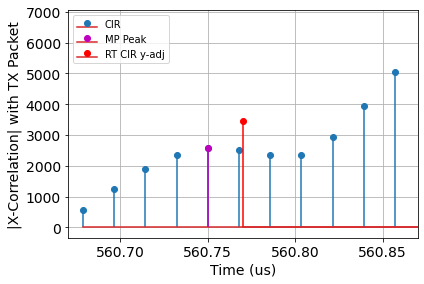

No Peak Match

RT CIR at 561.3107642857143 us is 10.664285714256039 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 433.801
Scaled RT CIR amplitude: 3051.956


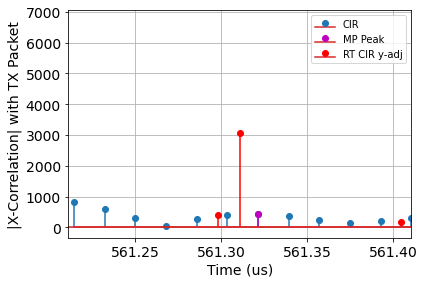

RT CIR at 560.9107142857143 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 6712.359
Scaled RT CIR amplitude: 6712.359

MATCH


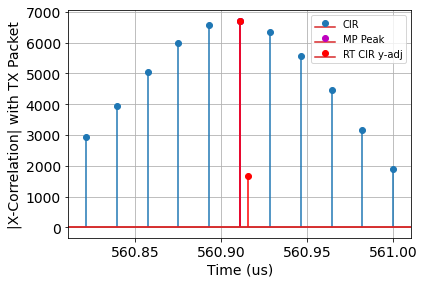

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

No Peak Match

RT CIR at 561.5433212857143 us is 10.250142857103128 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 369.724
Scaled RT CIR amplitude: 100.784


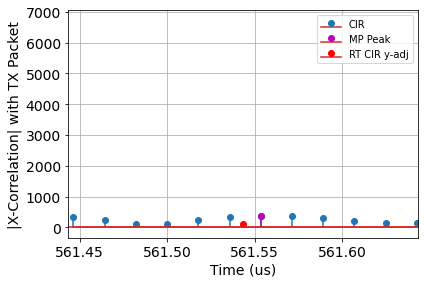

RT CIR at 561.4049242857143 us is 83.49571428573199 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 433.801
Scaled RT CIR amplitude: 170.758


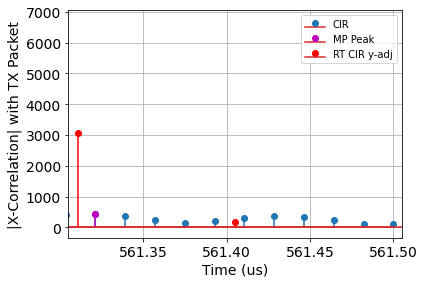

RT CIR at 561.2980812857144 us is 23.347285714180543 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 433.801
Scaled RT CIR amplitude: 395.956

MATCH


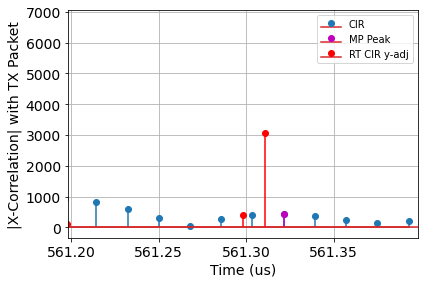

RT CIR at 561.1975482857143 us is 1.1197142857781728 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 930.06
Scaled RT CIR amplitude: 104.661


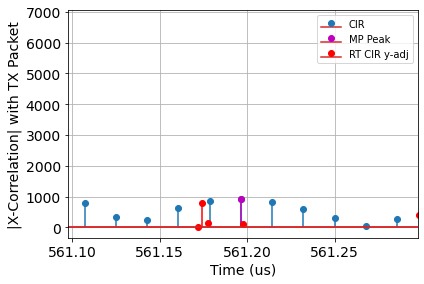

No Peak Match

No Peak Match

RT CIR at 561.1719342857143 us is 24.494285714240505 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 930.06
Scaled RT CIR amplitude: 23.759


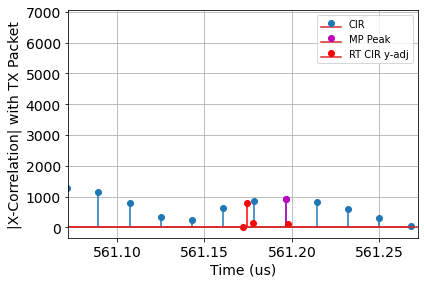

RT CIR at 561.1741542857144 us is 22.274285714161124 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 930.06
Scaled RT CIR amplitude: 783.867

MATCH


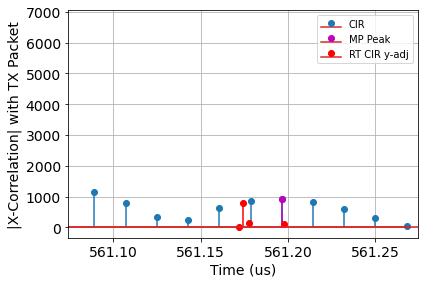

No Peak Match

No Peak Match

RT CIR at 560.9156442857143 us is 4.929999999944812 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 6712.359
Scaled RT CIR amplitude: 1660.79


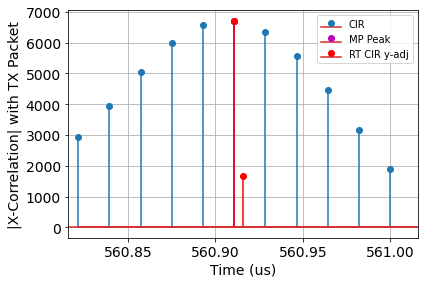

RT CIR at 561.1776982857143 us is 18.73028571424129 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 930.06
Scaled RT CIR amplitude: 141.008


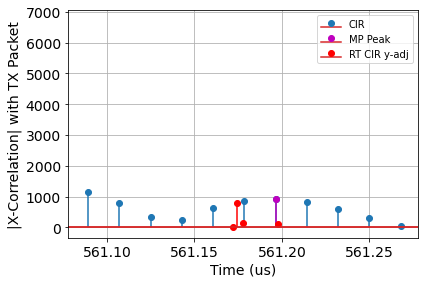

No Peak Match

No Peak Match



In [24]:
### Testing Cells


# Peak finding algorithm for multipath associated with RT results

# tau_plot
# a
#print('tau_plot: ' + str(tau_plot))
#print('a: ' + str(a) + '\n')

# Finding peak in area around RT multipath
def find_multipath_peak(local_cir):
    len_local = len(local_cir)
    
    for i in range(len_local):
        larger_than_prev = False
        larger_than_post = False
        
        if (i > 0) and (local_cir[i] >= local_cir[i-1]):
            larger_than_prev = True
        if (i < len_local - 1) and (local_cir[i] >= local_cir[i+1]):
            larger_than_post = True
        
        if larger_than_prev and larger_than_post:
            return i # index of peak element

def find_nearest_element(local_cir, value):
    local_cir = np.asarray(local_cir)
    near_ind = (np.abs(local_cir - value)).argmin()
    return near_ind #, local_cir[near_ind]

# testing peak finding
# arr = [1, 2, 4, 5, 7, 8, 9]
# print('testing peak finding with no peak:')
# print(find_multipath_peak(arr))
# print(find_nearest_element(arr, 1.2))

stau = find_nearest_element(lags, tau_plot[0])
cir_cropped = xcorr_mag[stau:]
lags_cropped = ((lags[stau:]/samp_rate)*1000000)
#cir_cropped = xcorr_mag[peak_ind:]
#lags_cropped = ((lags[peak_ind:]/samp_rate)*1000000)

limit = 0.1 # 100ns in us

#a_ind = 1
#for each in a[1:]:
a_ind = 0
for each in a_plot:
    lower_near_ind = find_nearest_element(lags_cropped, tau_plot[a_ind]-limit)
    upper_near_ind = find_nearest_element(lags_cropped, tau_plot[a_ind]+limit)
    cir_plot = cir_cropped[lower_near_ind:upper_near_ind+1]
    lags_plot = lags_cropped[lower_near_ind:upper_near_ind+1]
    
    local_peak_ind = find_multipath_peak(cir_plot)
    if (local_peak_ind != None) and (cir_plot[local_peak_ind] >= noise_std_thresh):
        #print('Multipath Peak Index found: ' + str(local_peak_ind) + '\nPeak amplitude: ' + str(cir_plot[local_peak_ind]))
        #print('Starting similarity analysis...\n')
        peak_diff = abs(lags_plot[local_peak_ind]-tau_plot[a_ind])*1000
        print('RT CIR at ' + str(tau_plot[a_ind]) + ' us is ' + str(peak_diff) + ' ns away from measured multipath peak.')
        if peak_diff <= 100:
            #amp_compare = each/cir_plot[local_peak_ind]
            #print('RT CIR amplitude:measured CIR at multipath peak = ' + str(round(amp_compare,3)))
            print('Measured Multipath Peak amplitude: ' + str(round(cir_plot[local_peak_ind],3)))
            print('Scaled RT CIR amplitude: ' + str(round(a_plot[a_ind],3)))
            
            sm_peak = min(cir_plot[local_peak_ind], a_plot[a_ind])
            if abs(cir_plot[local_peak_ind]-a_plot[a_ind]) <= (0.5*sm_peak):
                print('\nMATCH')
            
            plt.figure()
            plt.stem(lags_plot, cir_plot, label='CIR')
            plt.stem(lags_plot[local_peak_ind], cir_plot[local_peak_ind], label='MP Peak', linefmt='m-', markerfmt='mo')
            plt.stem(tau_plot, a_plot, label='RT CIR y-adj', linefmt='r-', markerfmt='ro')
            #plt.stem(tau_plot, a, label='RT CIR', linefmt='g-', markerfmt='go')
            plt.legend()
            plt.ylabel('|X-Correlation| with TX Packet', fontsize=14)
            plt.xlabel('Time (us)', fontsize=14)
            plt.xlim((tau_plot[a_ind]-limit,tau_plot[a_ind]+limit))
            #plt.ylim((0,500))
            plt.tight_layout()
            plt.grid(True)
            plt.show()
    
    else:
        #print('Moving to next RT peak...\n')
        print('No Peak Match\n')
        
    a_ind += 1

In [19]:
# Creating vectors

cir = []

for i in range(0,len(f_rttau)):
    cir.append(xcorr_mag[peak_ind + i])
    
cir = np.array(cir)
print('CIR vector:')
print(cir)

rt_cir = np.array(f_rta)
print('RT CIR vector:')
print(f_rta)

CIR vector:
[6712.35854059 6362.51047705 5574.23302853 4458.55902178 3174.0443564
 1913.20175022  949.23300511  814.15613049 1149.73844215 1290.86397799
 1152.0664087   793.98222267  330.98469567  241.95196272  616.86113786
  862.97760734  930.06042816  826.05501404  592.74456519  292.95495658
   45.94733883  259.07530584  402.32518734  433.80110797  364.70774828
  233.58582535  137.52034586  212.59572945  314.21939241  357.22391121
  326.51215886  231.80414288  106.20223473  105.89737417  229.54335837
  325.73980081  369.72417211  357.84372999  299.36600069  214.93417295
  141.20764792  134.34722829  180.42526248  221.87997812  240.06276381
  235.95004356  218.40532219  198.46221286  183.90187003  175.62090531
  169.71519756  162.89739252  155.08085934  148.09335011  142.99391866
  138.75118948  133.42751394  126.29344267  118.90753818  114.52793513
  115.9897247   123.59144486  135.42049511  149.32243898  163.90901229
  178.28186591  191.46740984  202.24433866]
RT CIR vector:
[3.1455

In [20]:
# Finding the Kernel Distance between experimental CIR and RT CIR

# Gaussian Kernel Distance
# K(x,y) = exp(-||x-y||^2/sigma^2)
# K(x,x) = 1

def gaussian_kernel_K(p, q, sigma=1.0):
    return np.exp(-1 * np.sum((p-q)**2) / (sigma**2))

# Gaussian Kernel Distance
# k_pp' + k_qq' - 2 * k_pq

def kernel_dist(cir, rt_cir, sigma=1.0):
    distance = 0
    for p in cir:
        for pp in cir:
            distance += gaussian_kernel_K(p,pp)
    
    for q in rt_cir:
        for qp in rt_cir:
            distance += gaussian_kernel_K(q,qp)
    
    sub_dist = 0
    for p in cir:
        for q in rt_cir:
            sub_dist += gaussian_kernel_K(p,q)
    
    distance = distance - (2*sub_dist)
    return distance

# Test identity property
print('Gaussian Kernel')
K = gaussian_kernel_K(cir,cir)
print('K(cir,cir) = ' + str(K)) # correctly = 1.0

K = gaussian_kernel_K(cir, rt_cir)
print('K(cir,rt_cir) = ' + str(K))

print('\nGaussian Kernel Distance')
DK = kernel_dist(cir,cir)
print('DK(cir,cir) = ' + str(DK)) # close to 0

DK = kernel_dist(cir,rt_cir)
print('DK(cir,rt_cir) = ' + str(DK))

Gaussian Kernel
K(cir,cir) = 1.0
K(cir,rt_cir) = 0.0

Gaussian Kernel Distance
DK(cir,cir) = 5.684341886080802e-14
DK(cir,rt_cir) = 4699.962067759365


<StemContainer object of 3 artists>

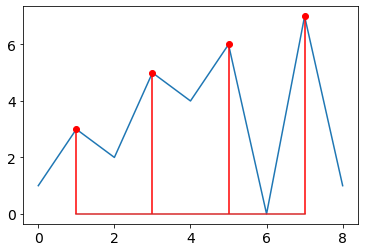

In [28]:
# Testing local peak finding

arr = np.array([1, 3, 2, 5, 4, 6, 0, 7, 1])

peak_indicies, _ = find_peaks(arr)

peaks = []

for each in peak_indicies:
    peaks.append(arr[each])

plt.plot(arr)
plt.stem(peak_indicies, peaks, 'r')
